# Developing intuition with a library of models

While the helical random field and the IMAGINE fitting are not fully working, it is worth start developing intuition about SN shells. This notebook aims helping on this, constructing a library of models displaying different parameter choices.

We start with the case of very close wavelengths. Later we can look at realistically coarse separation of frequencies.


## Model description

The model comprises a shell which develped on an medium which contained an initially uniform magnetic field $\vec{B}=(B_x, B_y, B_z)$ and a Gaussian random component with $\langle b \rangle=0$ and $b_{\rm rms} \propto B$.

The inital electron density distribution is also assumed to be uniform. The final cosmic ray distribution can *either* be proportional to the *final* electron density (i.e. CRs on the shell) or proportional to the *initial* thermal electorn distribution (i.e. uniform CRs).

## Basic setup

In [1]:
import os, sys
sys.path.append('../')

import shell.observable as obs
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import imagine as img
import shell.visualization as visu

We will use a common grid for all the calculations

In [2]:
L = 70*u.pc; N = 150

grid = img.fields.UniformGrid(# coordinate values for edges of the grid box
                              box=[[-L,L],[-L,L],[-L,L]], 
                              # Grid resolution
                              resolution=[N, N, N])

The naive random field previously defined in notebook 4 was copied to the fields module, with some adjustments.

Now, I defined a helper class which contains the full specficiation of the model and stores the relevant quantities during one particular evaluation. This is done in a very inefficient fashion, as clarity is the main goal. 

I saved the helper class in this notebooks directory:

In [3]:
import shell.model_helper as helper
helper.Model?

Init signature:
helper.Model(
    grid,
    shell_parameters={},
    ne=<Quantity 1. 1 / cm3>,
    Brnd_B=1,
    B=[<Quantity 0. uG>, <Quantity 0. uG>, <Quantity 0. uG>],
    ncr_ne=1,
    shell_a=None,
    shell_b=None,
    cr_type='thermal',
    B_type='uniform',
    period=<Quantity 70. pc>,
    freqs=[<Quantity 1.4 GHz>, <Quantity 1.42 GHz>],
    gamma=1,
)
Docstring:     
Helper class to make it easier to construct the model library

Parameters
----------
grid
    IMAGINE grid object
shell_parameters : dict
    Dictionary containing parameters of the SN shell which
    one wants to modify
shell_a, shell_b : float
    Shell a and b parameters (overrides `shell_parameters`)
cr_type : str
    Type of CR model. May be 'thermal' i.e. CRE proportional to
    the TE, or 'uniform', i.e. CRe constant.
ncr_ne : float
    The ratio of CRE to TE.
B_type : str
    Type of B model. May be 'uniform' or 'helical'
B : list
    A list containing the magnitude of the tree modes from which
    the B 

Observables (e.g. Q) appear in lists (one item per input frequency) while physical quantities (e.g. Bx) not. 
Note that the RM property is computed combining 2 consecutive wavelengths. Thus , it contains less elements than, say, stokes Q. 

The helicity estimate is also included. It is both computed *directly* and estimated from the observables.

Let us test this

In [4]:
import astropy.units as u
muG = u.microgauss

In [10]:
def show_model(grid, test_model):
    fig, ax = plt.subplots(2, 3, figsize=(12,5),dpi=200)
    
    visu.plot_vector_xy(grid, [test_model.Bx,test_model.By,test_model.Bz],  ax=ax[0,0], skip=8)
    visu.plot_polarization_vector(grid, I=test_model.I[0], PI=test_model.PI[0], PA=test_model.Psi[0],skip=5, ax=ax[0,1])
    visu.plot_scalar_xy(grid, test_model.I[0], name=r'{\rm I}', ax=ax[0,2])
    
    visu.plot_scalar_xy(grid, test_model.RM[0], name=r'{\rm RM}', ax=ax[1,0], vmin=-175, vmax=175)
    visu.plot_scalar_xy(grid, test_model.Q[0], name=r'{\rm Q}', ax=ax[1,1])
    visu.plot_scalar_xy(grid, test_model.U[0], name=r'{\rm U}', ax=ax[1,2])
    
    plt.tight_layout()

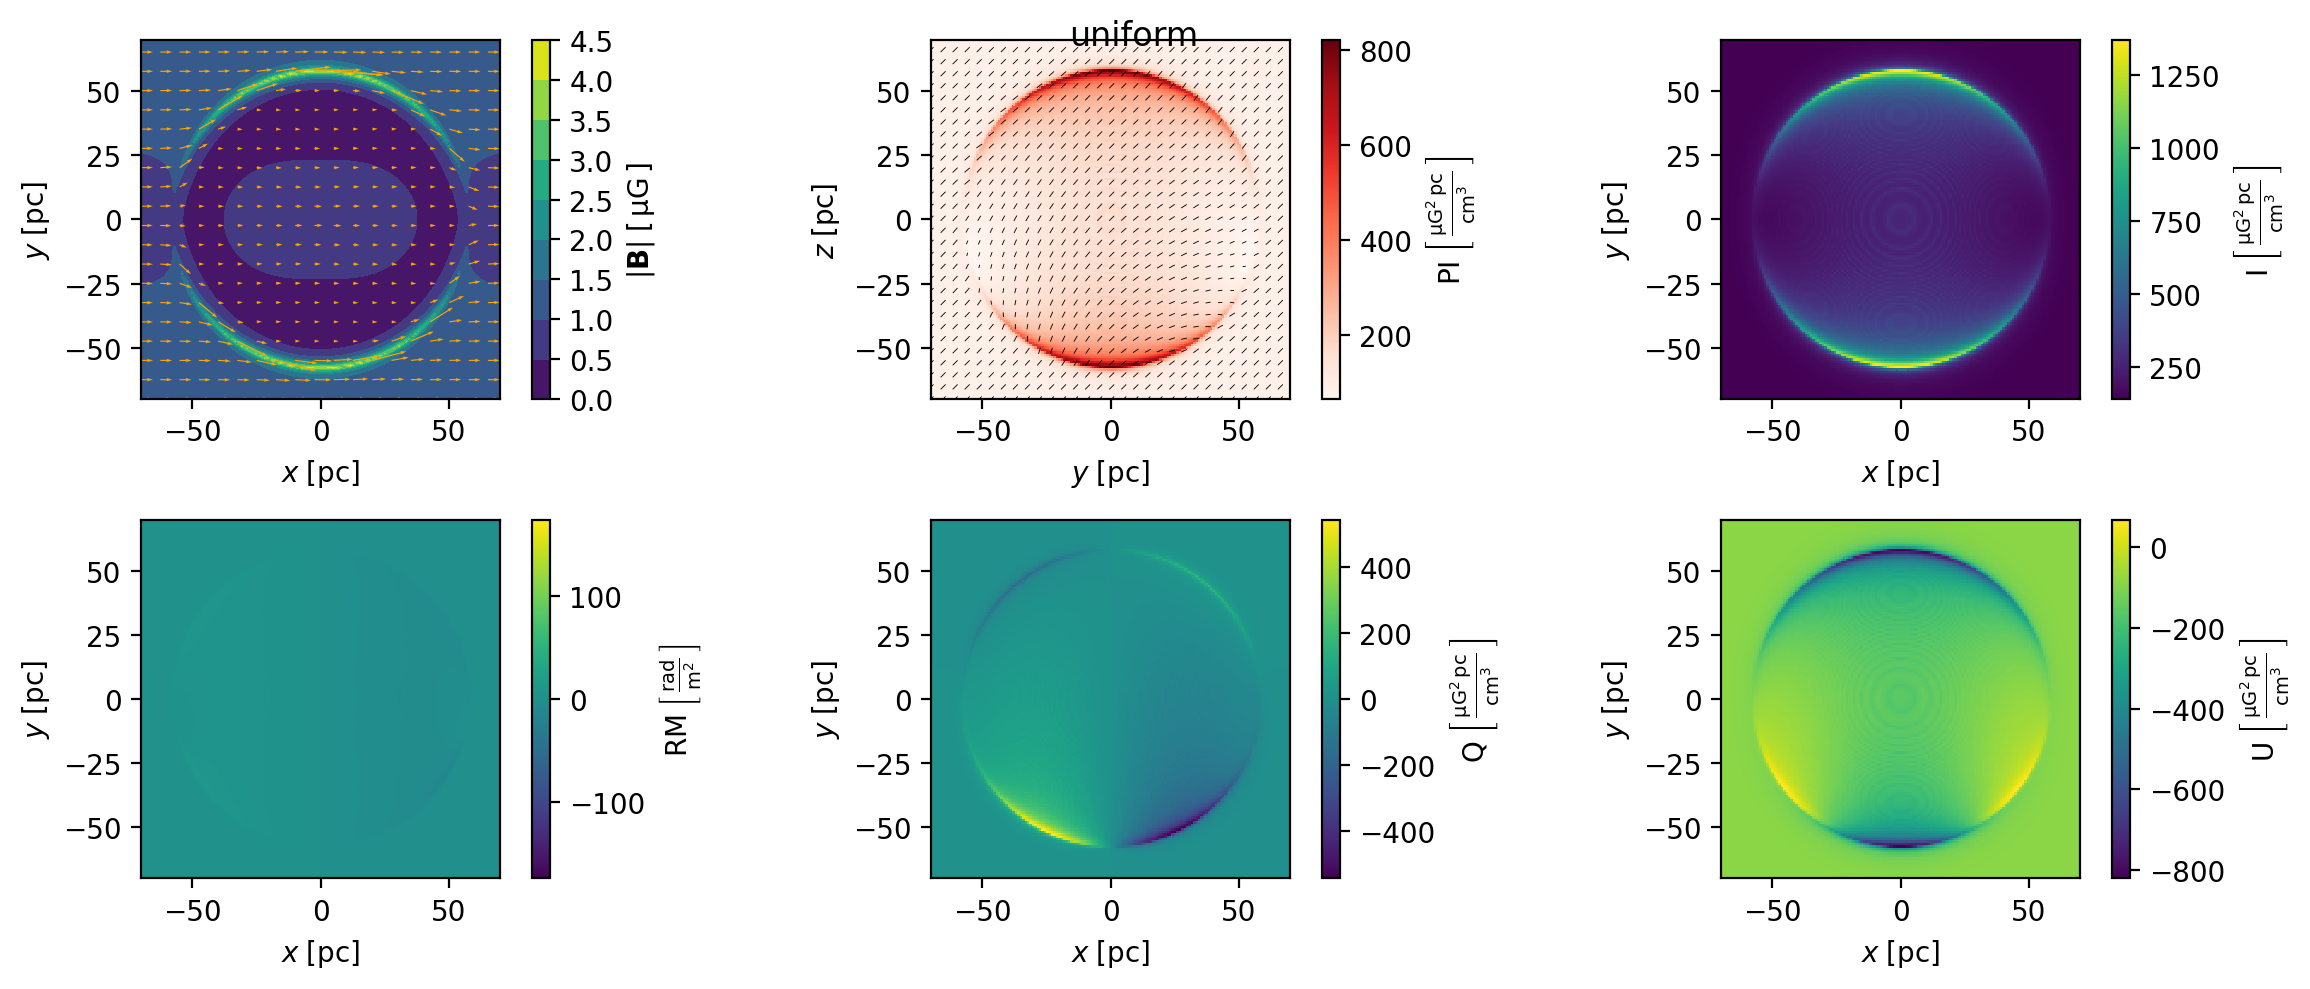

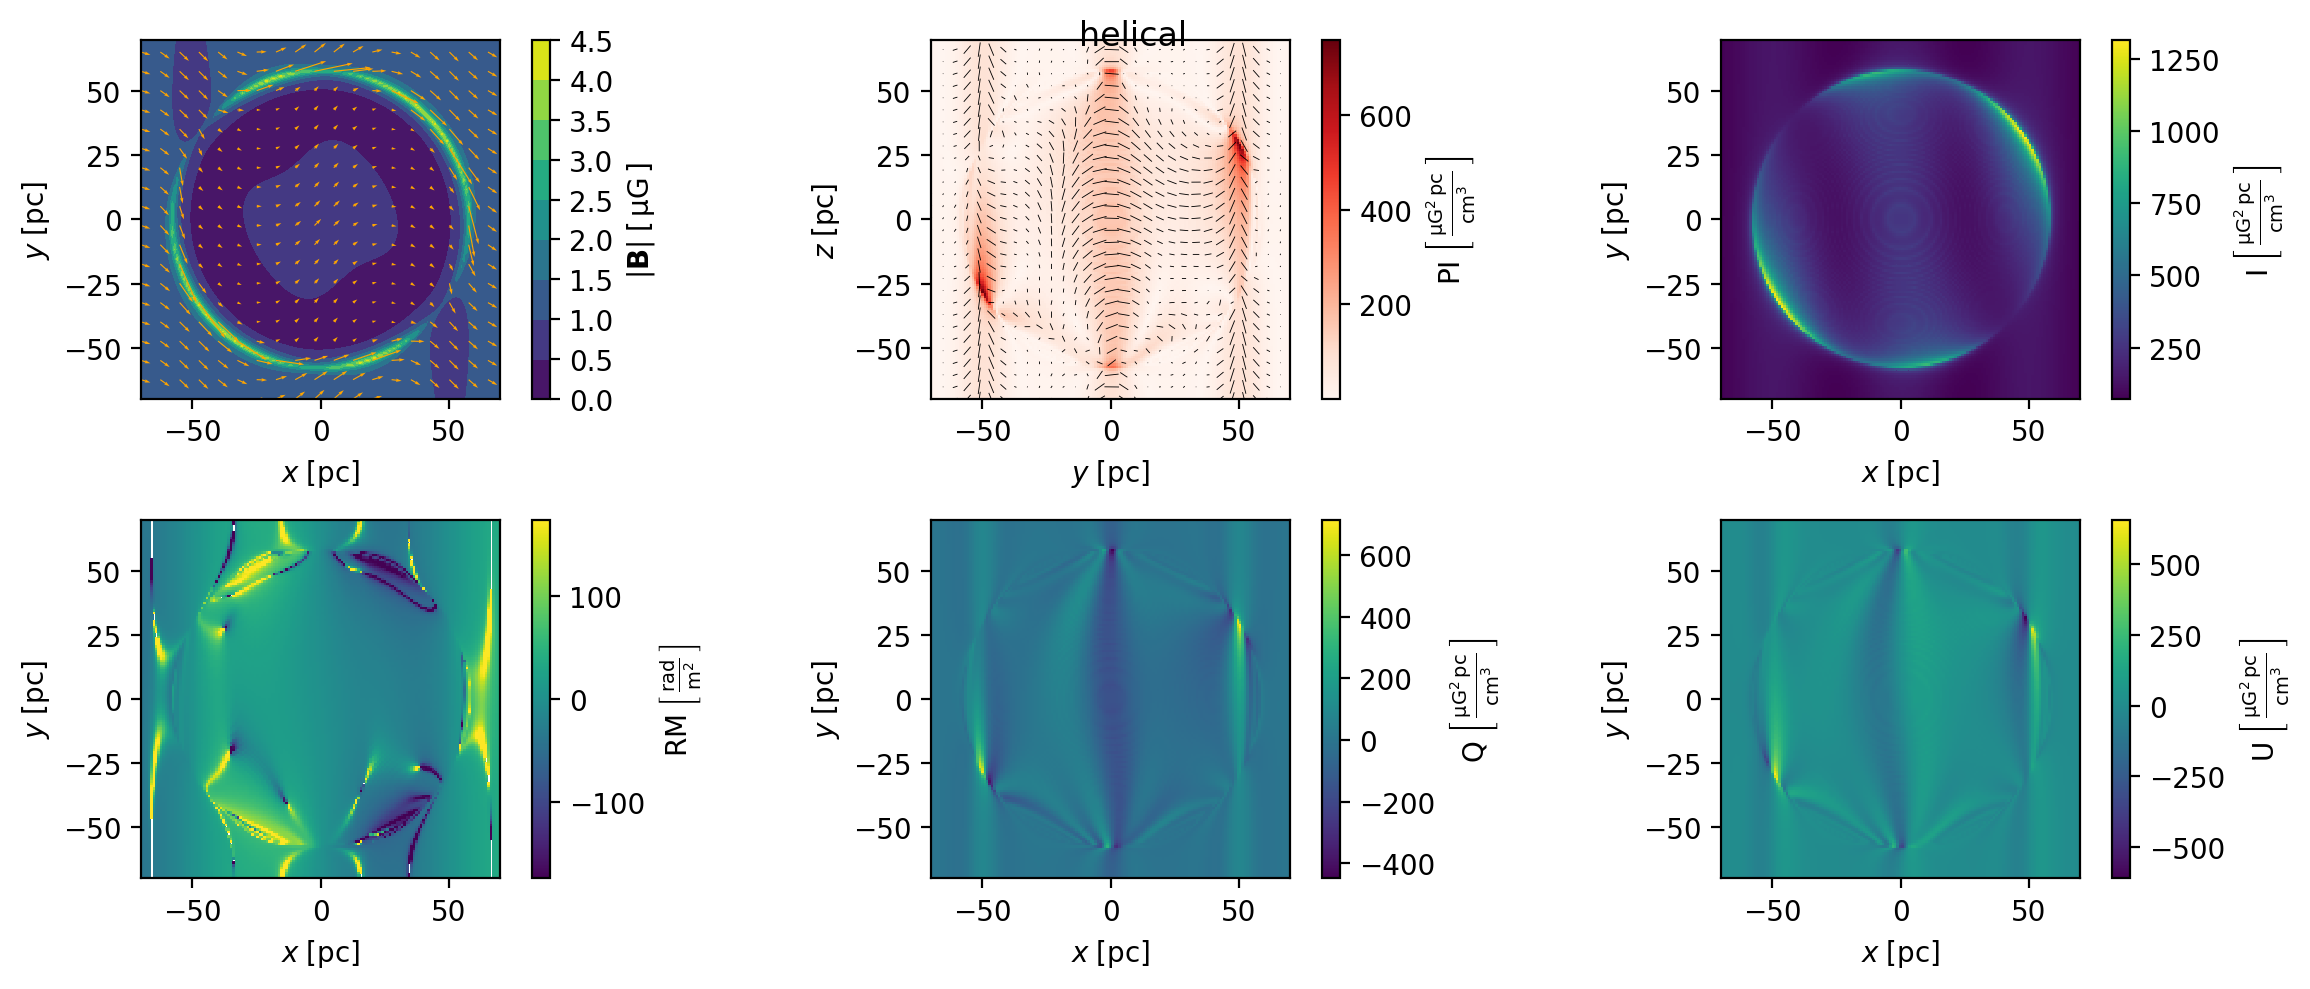

In [11]:
for B_type in ('uniform','helical'):
    test_model = helper.Model(grid, B=[1, 0, 0.0]*muG, B_type=B_type, 
                              period=50*u.pc,  # <== Sets the period!
                              freqs=[1.4, 1.401]*u.GHz, Brnd_B=0)
    show_model(grid, test_model)
    plt.suptitle(B_type)

## Parameters grid

The following sets the grid possible parameters manually

In [7]:
grid_layout = dict(
    B = [ [1,0,0],
          [0,0,1],
          [0,1,0] ]*u.microgauss,
    freqs = [[1.4, 1.401]*u.GHz],
    shell_a = [1.3,0.7,2],
    shell_b = [10,5,15],
    cr_type = ['uniform','thermal'],
    B_type = ['helical'],  ## <== Uniform case was removed
    Brnd_B = [0,0.1,0.5],  
    ncr_ne = [0.1, 1],
    ne = [0.1, 0.5, 1]*u.cm**-3,
    period = [70*u.pc, 35*u.pc, 140*u.pc]  # <== Period!
)

In [13]:
import itertools

# Sets the order of the keys we will be using
keys = [
     'ncr_ne',
     'ne',
     'freqs',
     'cr_type',
     'B',
     'Brnd_B',
     'shell_a',
     'shell_b',
     'B_type',
     'period'
     ]

values = [grid_layout[k] for k in keys]

permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
# Very cool trick based on: 
# https://stackoverflow.com/questions/38721847/how-to-generate-all-combination-from-values-in-dict-of-lists-in-python#38722093

In [9]:
def print_param_dict(i, d):
    print('Model',i+1)
    for k, v in d.items():
        print('  {0:8}-> '.format(k), v)

Model 1
  ncr_ne  ->  0.1
  ne      ->  0.1 1 / cm3
  freqs   ->  [1.4   1.401] GHz
  cr_type ->  uniform
  B       ->  [1. 0. 0.] uG
  Brnd_B  ->  0
  shell_a ->  1.3
  shell_b ->  10
  B_type  ->  helical
  period  ->  70.0 pc


../shell/visualization.py:103: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  PI.value, **kwargs)
../shell/visualization.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im_slice.value, **kwargs)


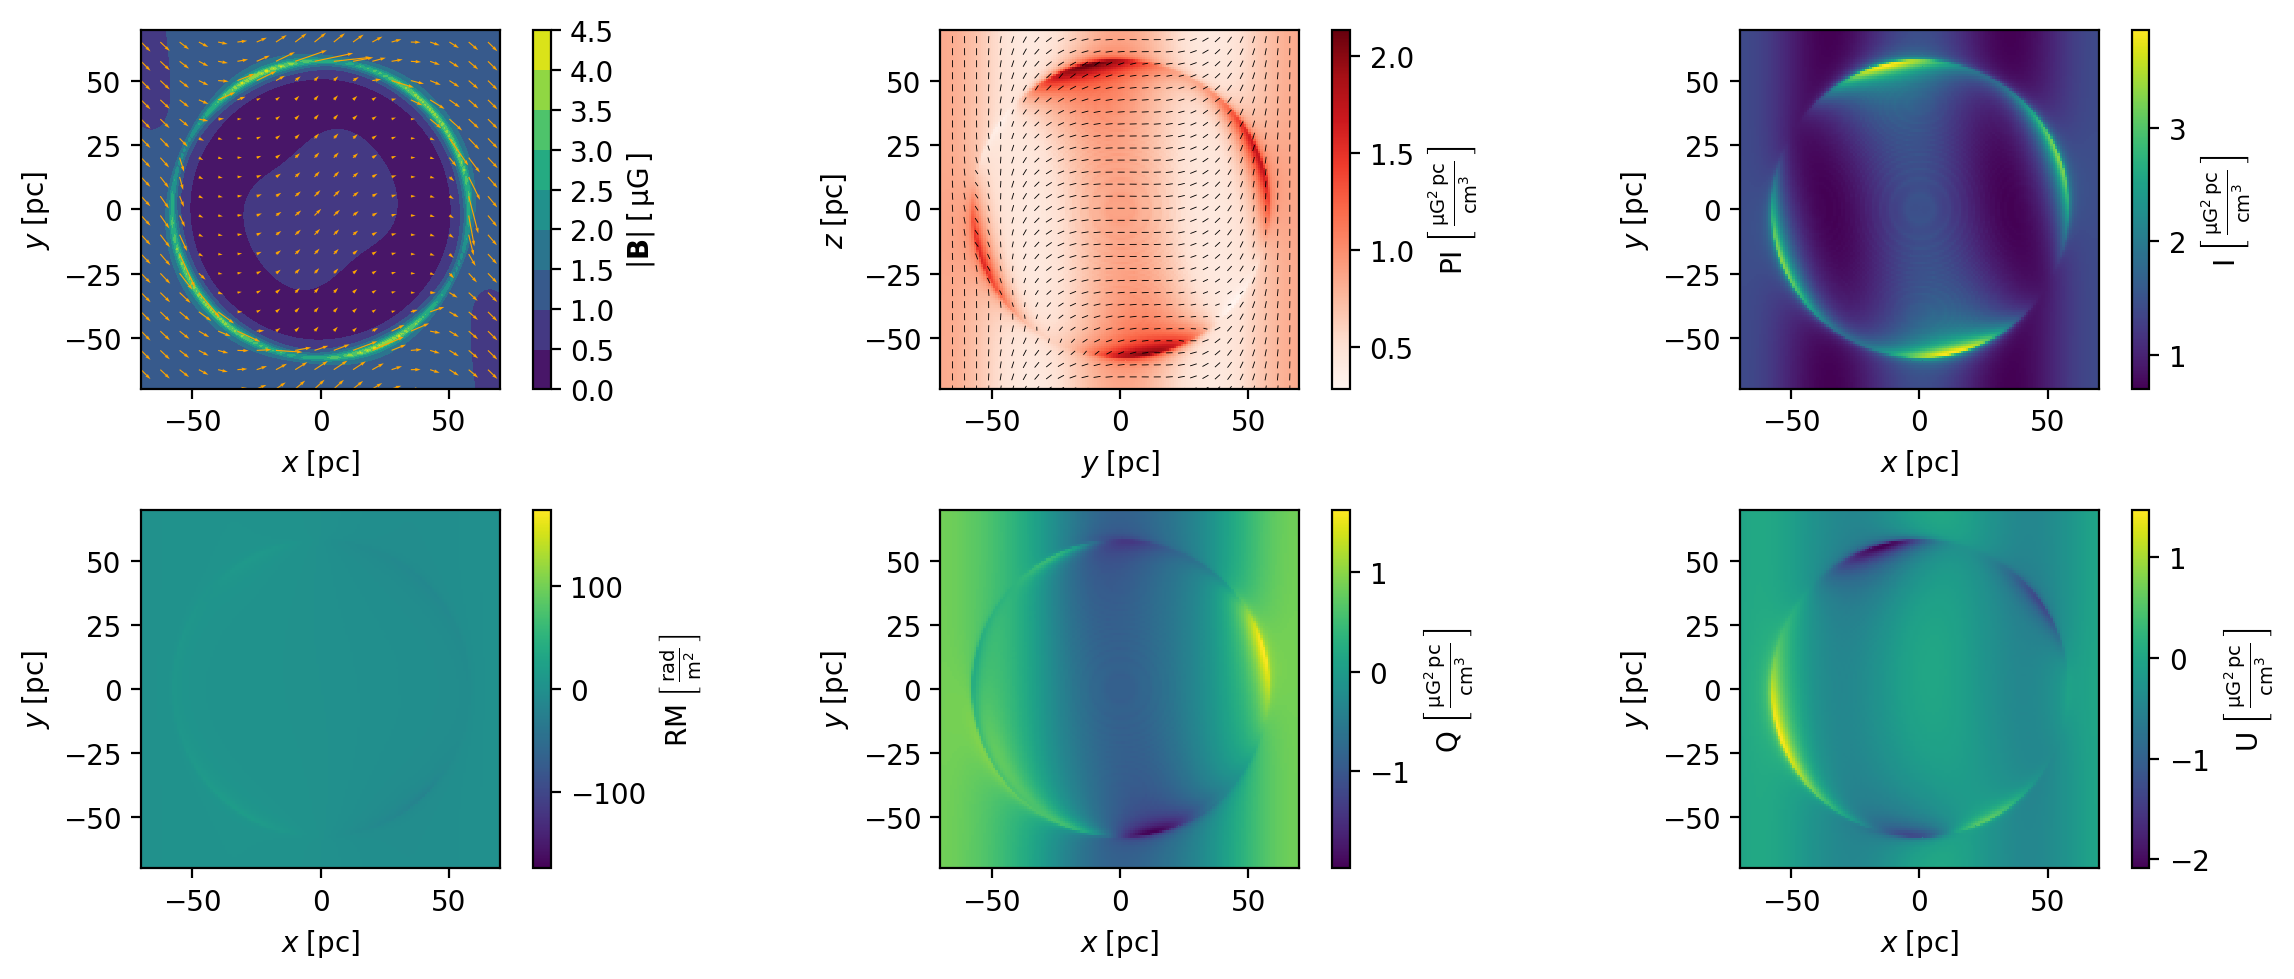

Model 2
  ncr_ne  ->  0.1
  ne      ->  0.1 1 / cm3
  freqs   ->  [1.4   1.401] GHz
  cr_type ->  uniform
  B       ->  [1. 0. 0.] uG
  Brnd_B  ->  0
  shell_a ->  1.3
  shell_b ->  10
  B_type  ->  helical
  period  ->  35.0 pc


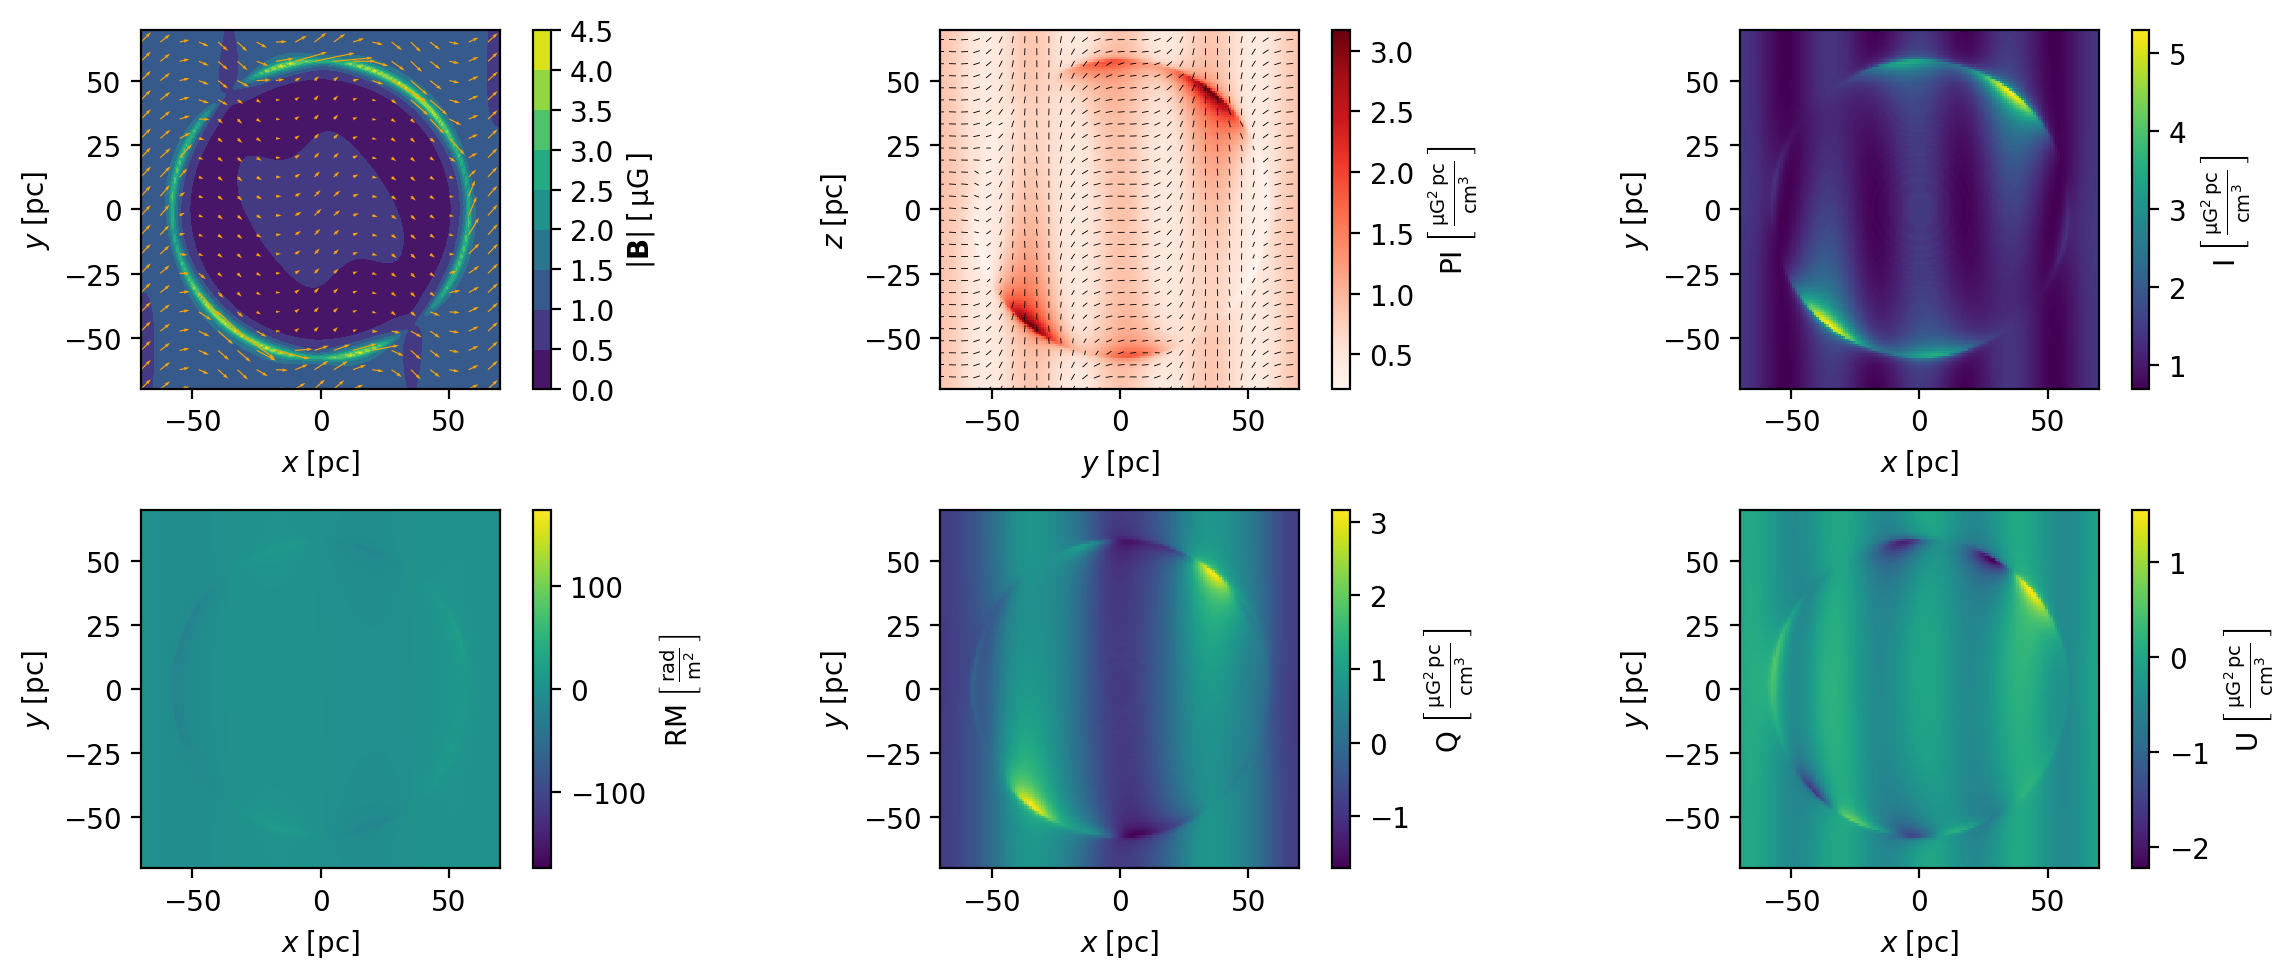

Model 3
  ncr_ne  ->  0.1
  ne      ->  0.1 1 / cm3
  freqs   ->  [1.4   1.401] GHz
  cr_type ->  uniform
  B       ->  [1. 0. 0.] uG
  Brnd_B  ->  0
  shell_a ->  1.3
  shell_b ->  10
  B_type  ->  helical
  period  ->  140.0 pc


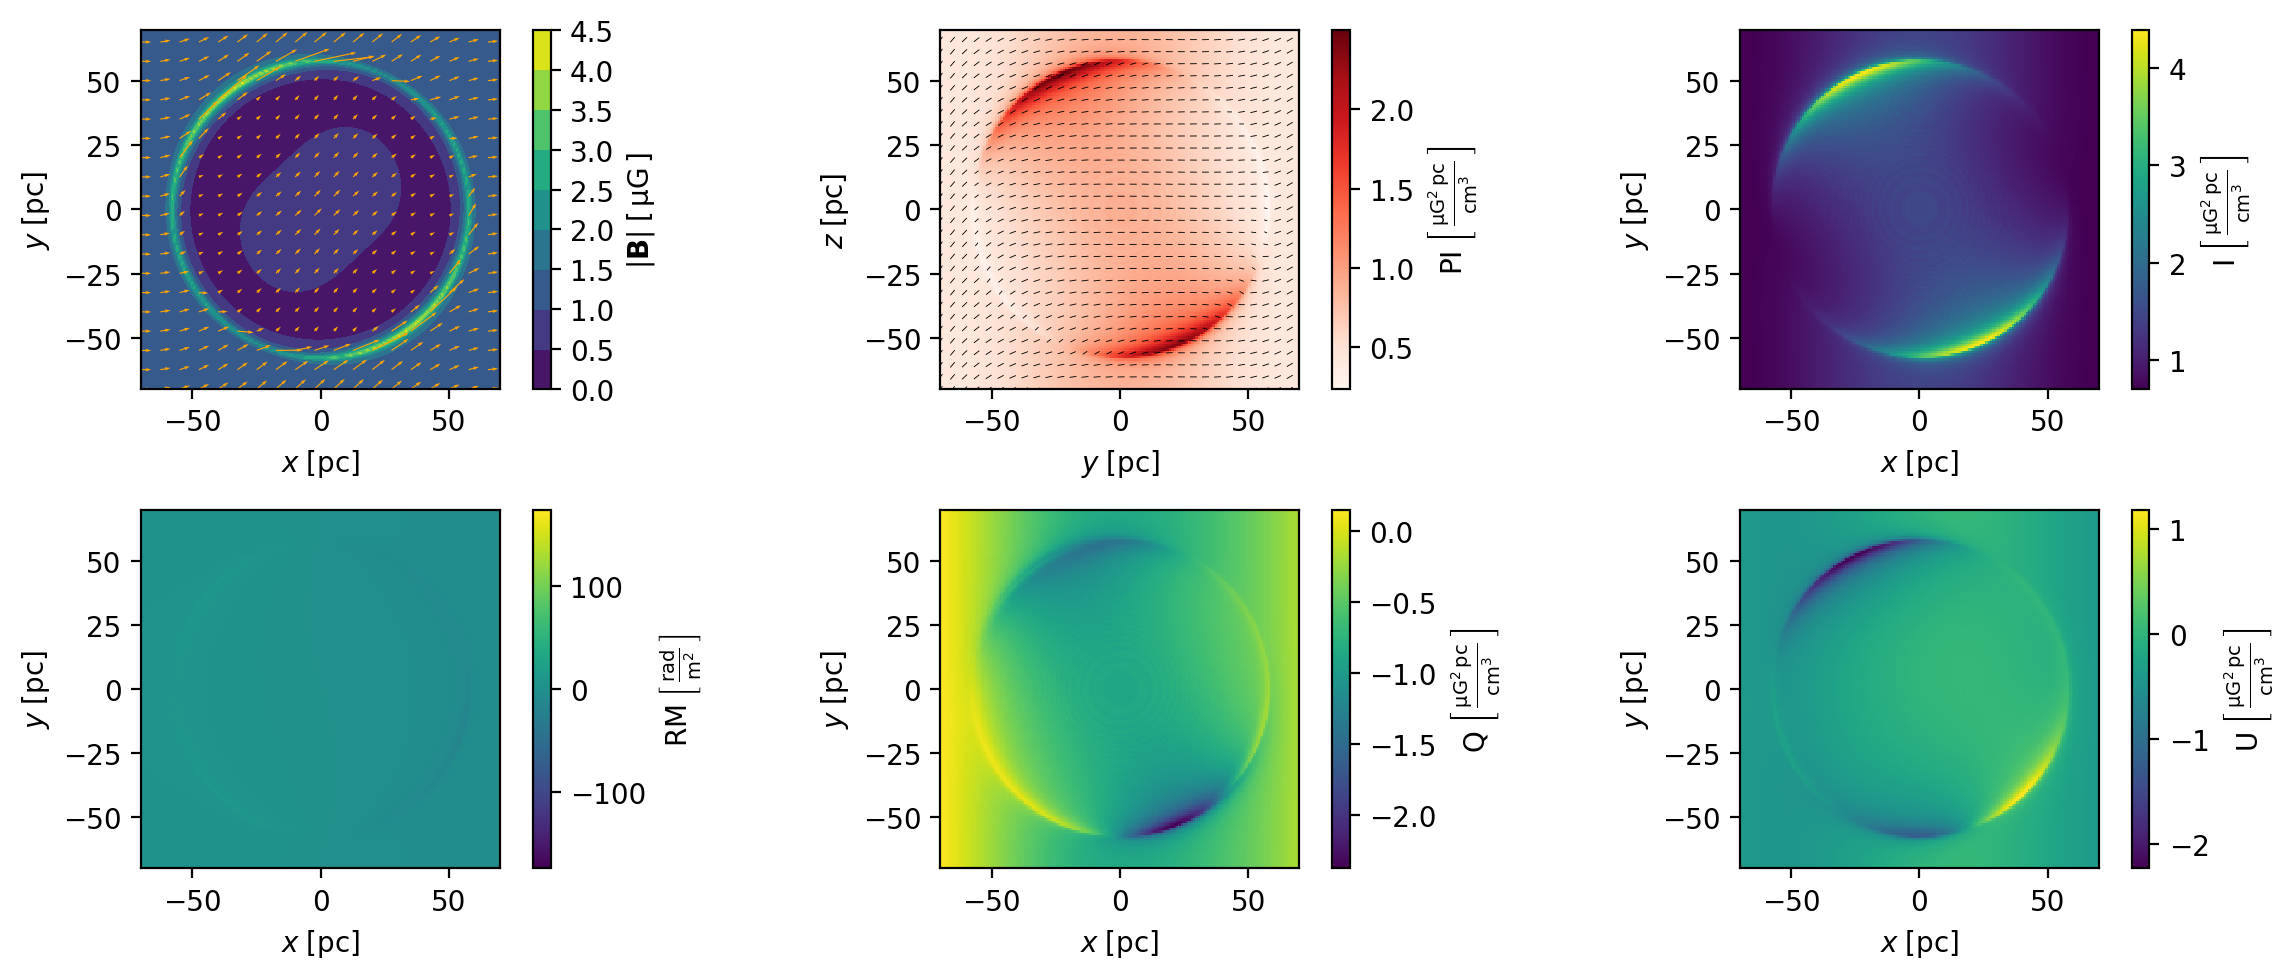

Model 4
  ncr_ne  ->  0.1
  ne      ->  0.1 1 / cm3
  freqs   ->  [1.4   1.401] GHz
  cr_type ->  uniform
  B       ->  [1. 0. 0.] uG
  Brnd_B  ->  0
  shell_a ->  1.3
  shell_b ->  5
  B_type  ->  helical
  period  ->  70.0 pc


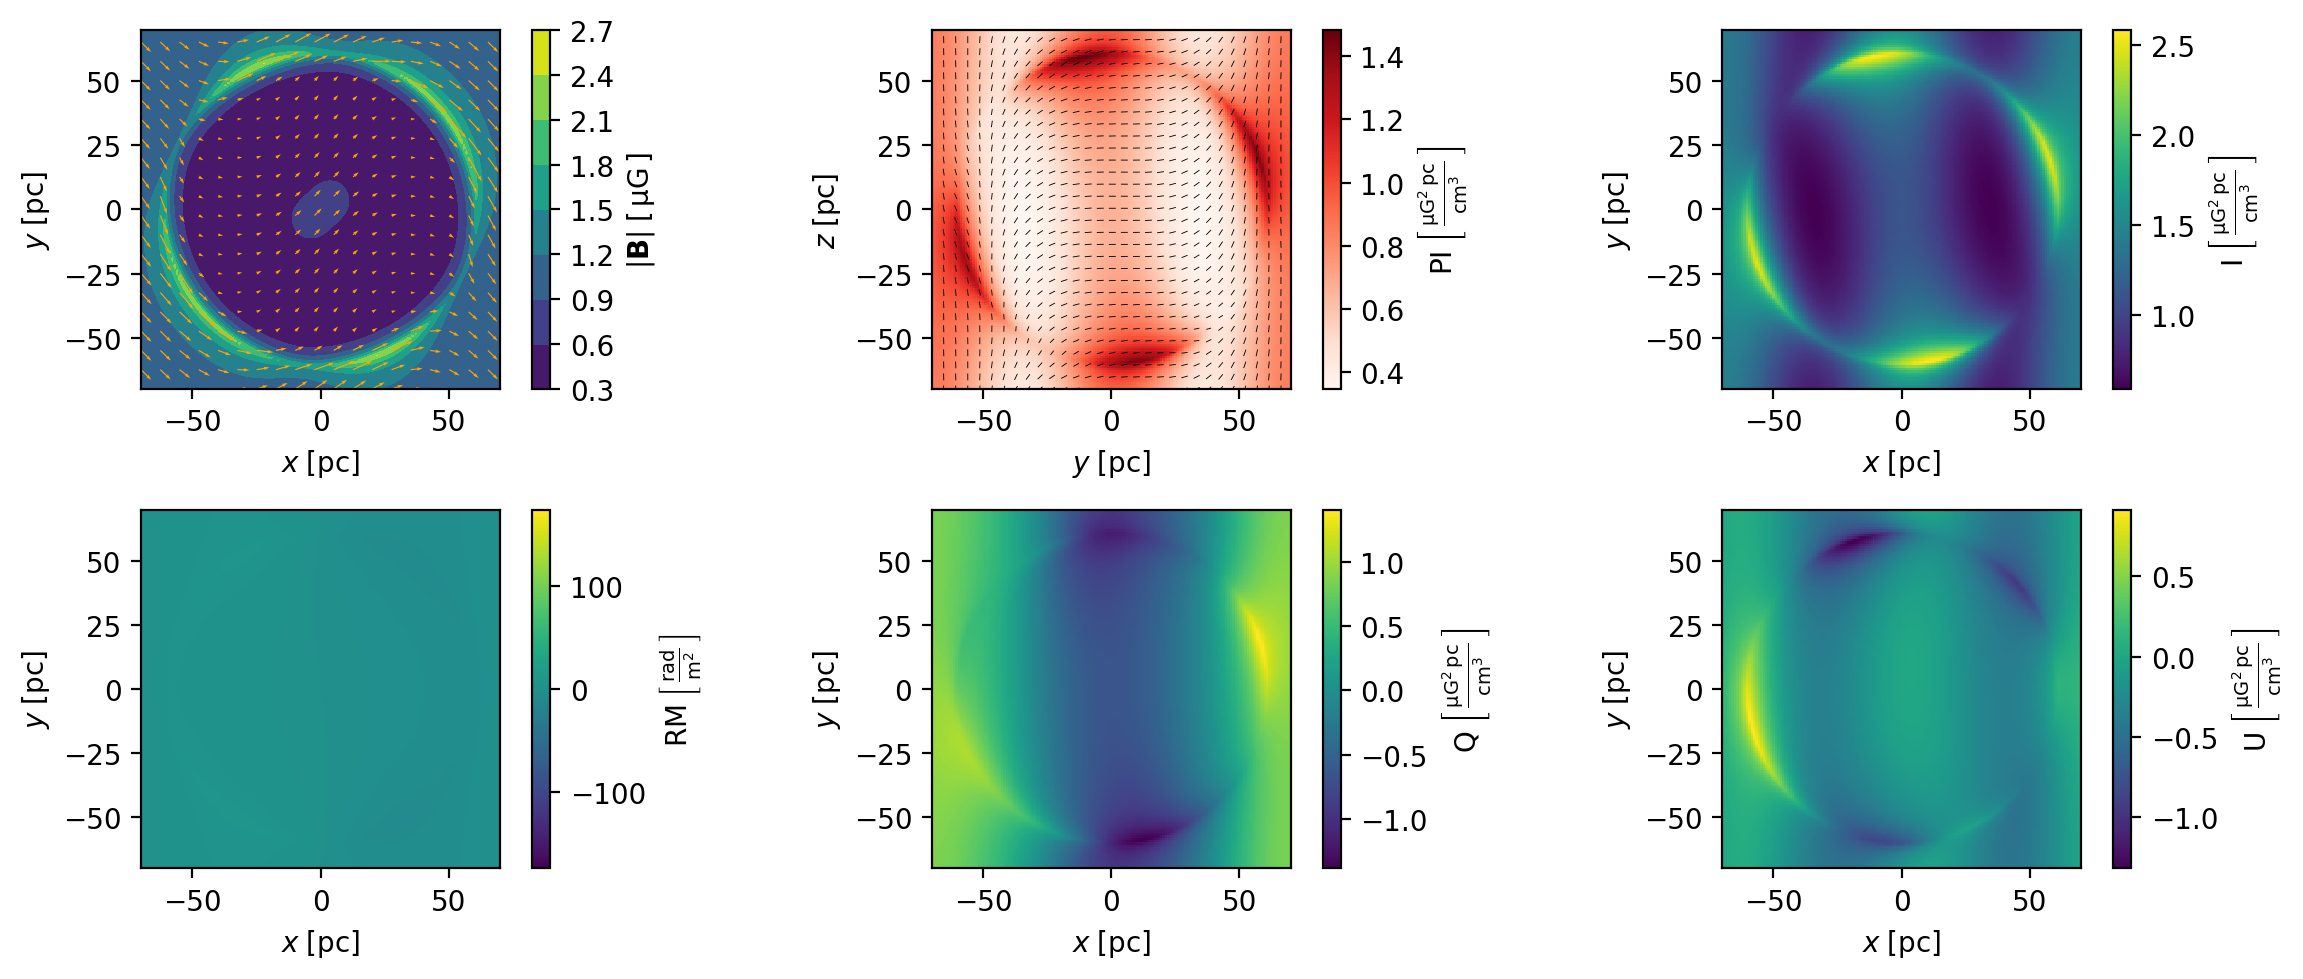

Model 5
  ncr_ne  ->  0.1
  ne      ->  0.1 1 / cm3
  freqs   ->  [1.4   1.401] GHz
  cr_type ->  uniform
  B       ->  [1. 0. 0.] uG
  Brnd_B  ->  0
  shell_a ->  1.3
  shell_b ->  5
  B_type  ->  helical
  period  ->  35.0 pc


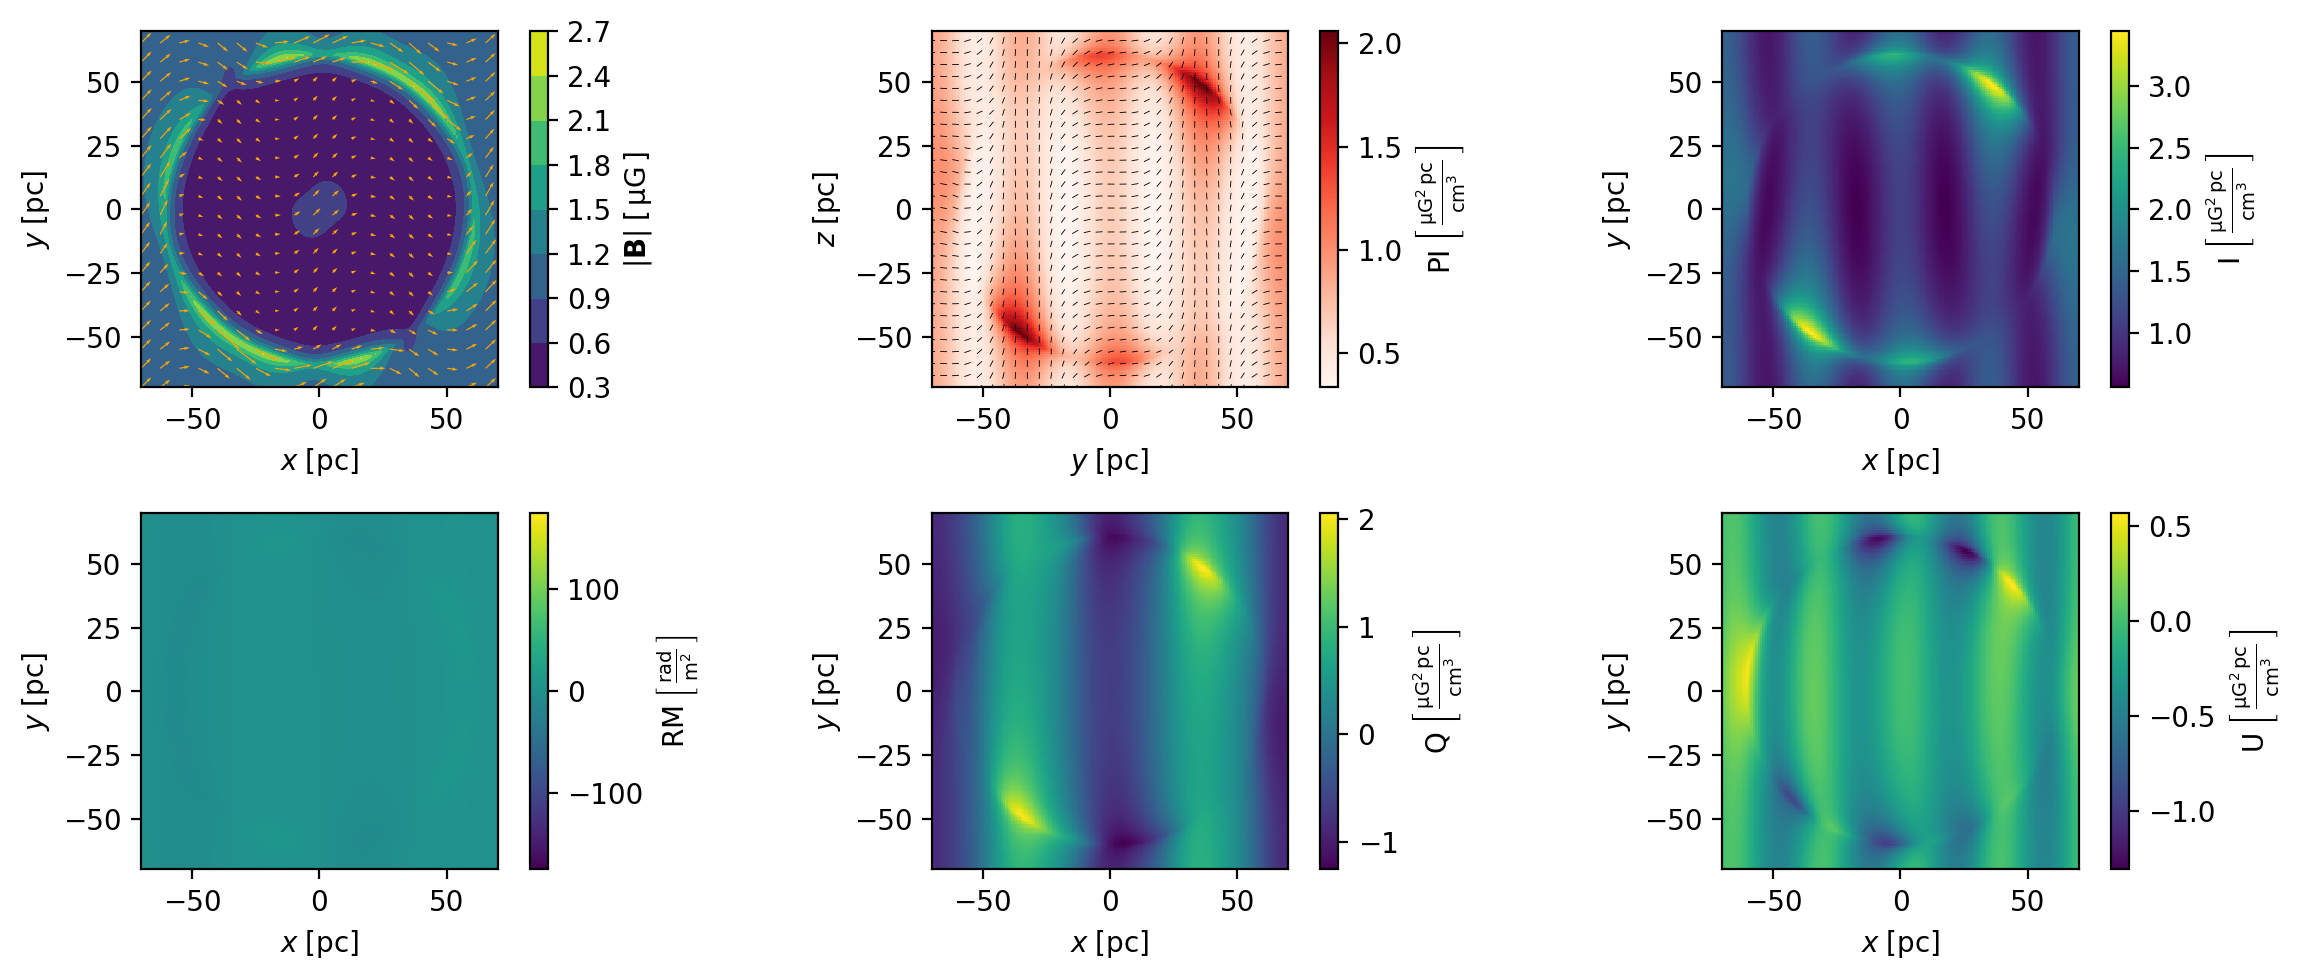

Model 6
  ncr_ne  ->  0.1
  ne      ->  0.1 1 / cm3
  freqs   ->  [1.4   1.401] GHz
  cr_type ->  uniform
  B       ->  [1. 0. 0.] uG
  Brnd_B  ->  0
  shell_a ->  1.3
  shell_b ->  5
  B_type  ->  helical
  period  ->  140.0 pc


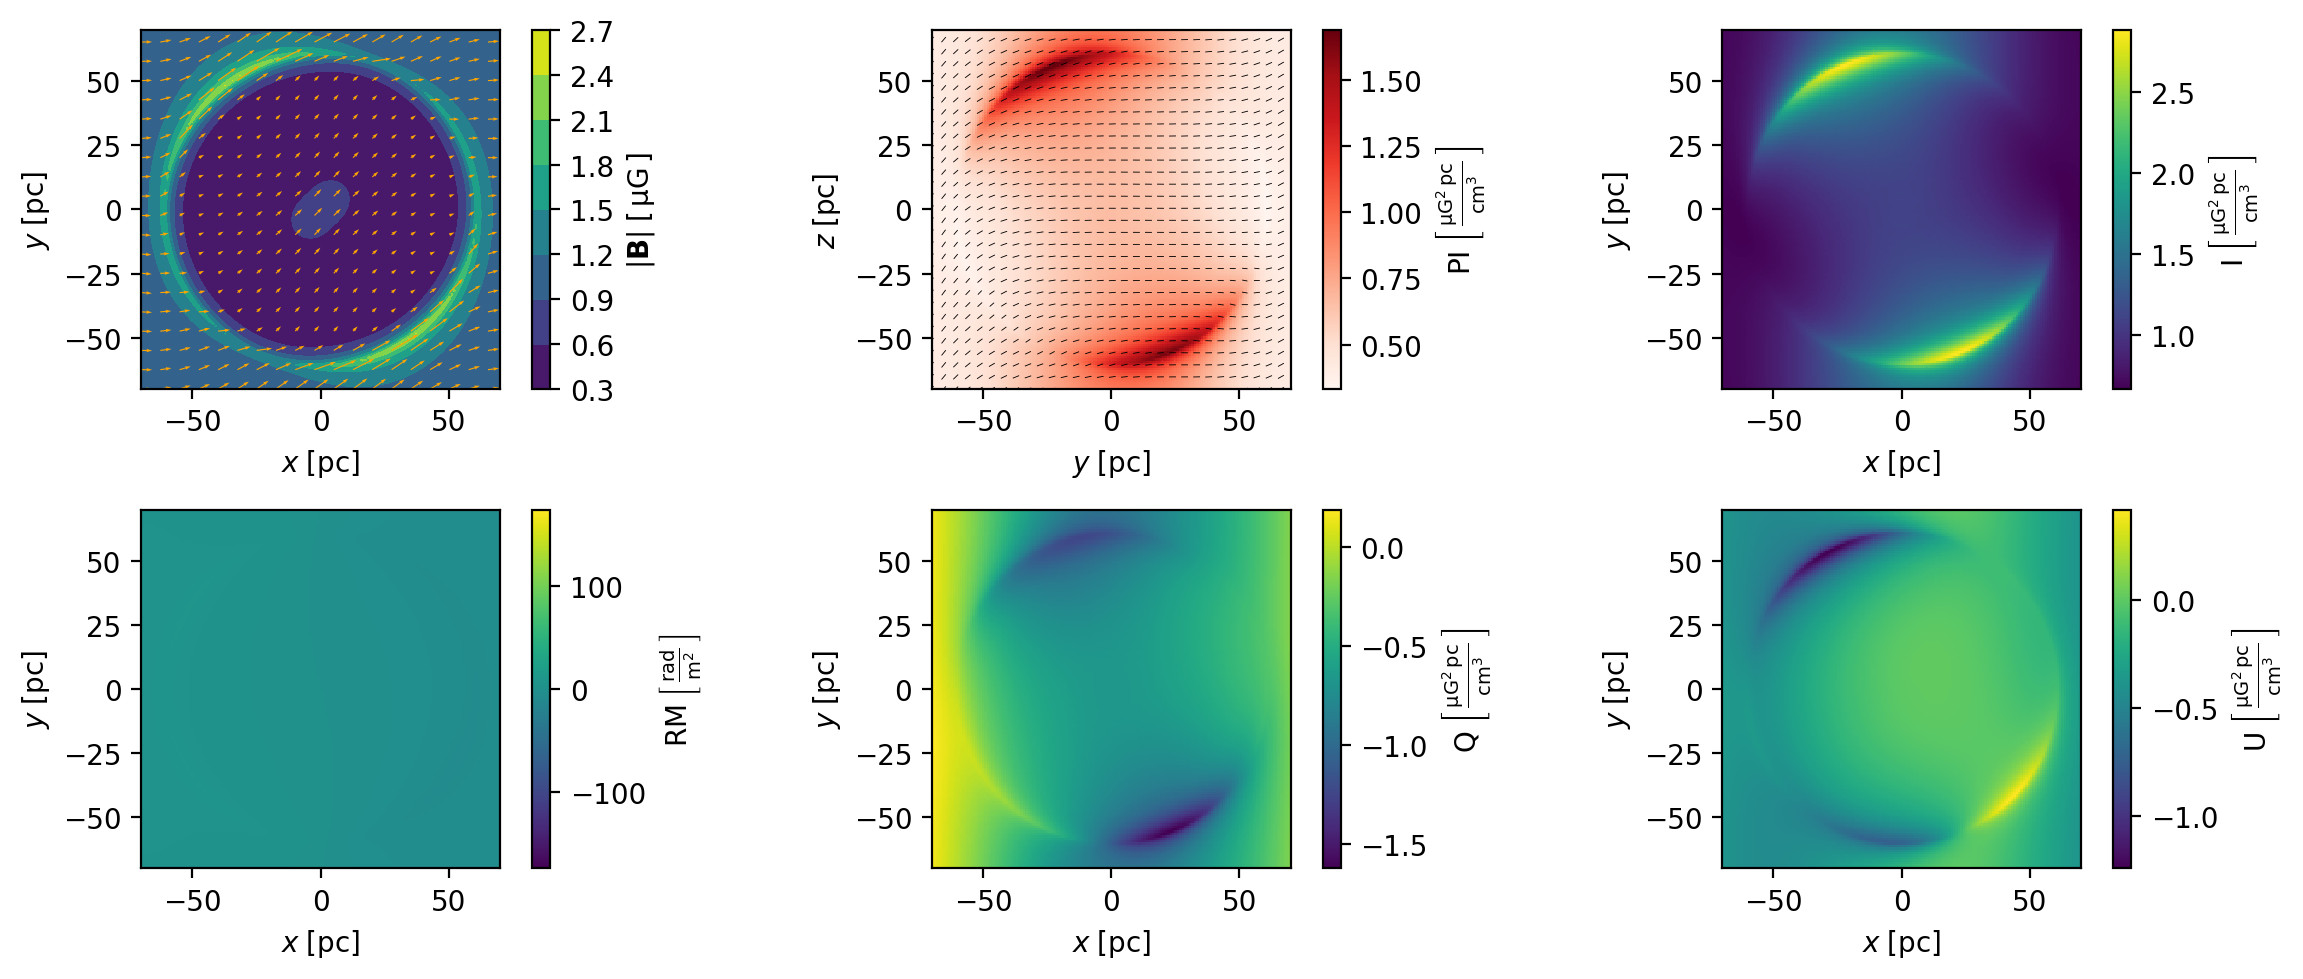

Model 7
  ncr_ne  ->  0.1
  ne      ->  0.1 1 / cm3
  freqs   ->  [1.4   1.401] GHz
  cr_type ->  uniform
  B       ->  [1. 0. 0.] uG
  Brnd_B  ->  0
  shell_a ->  1.3
  shell_b ->  15
  B_type  ->  helical
  period  ->  70.0 pc


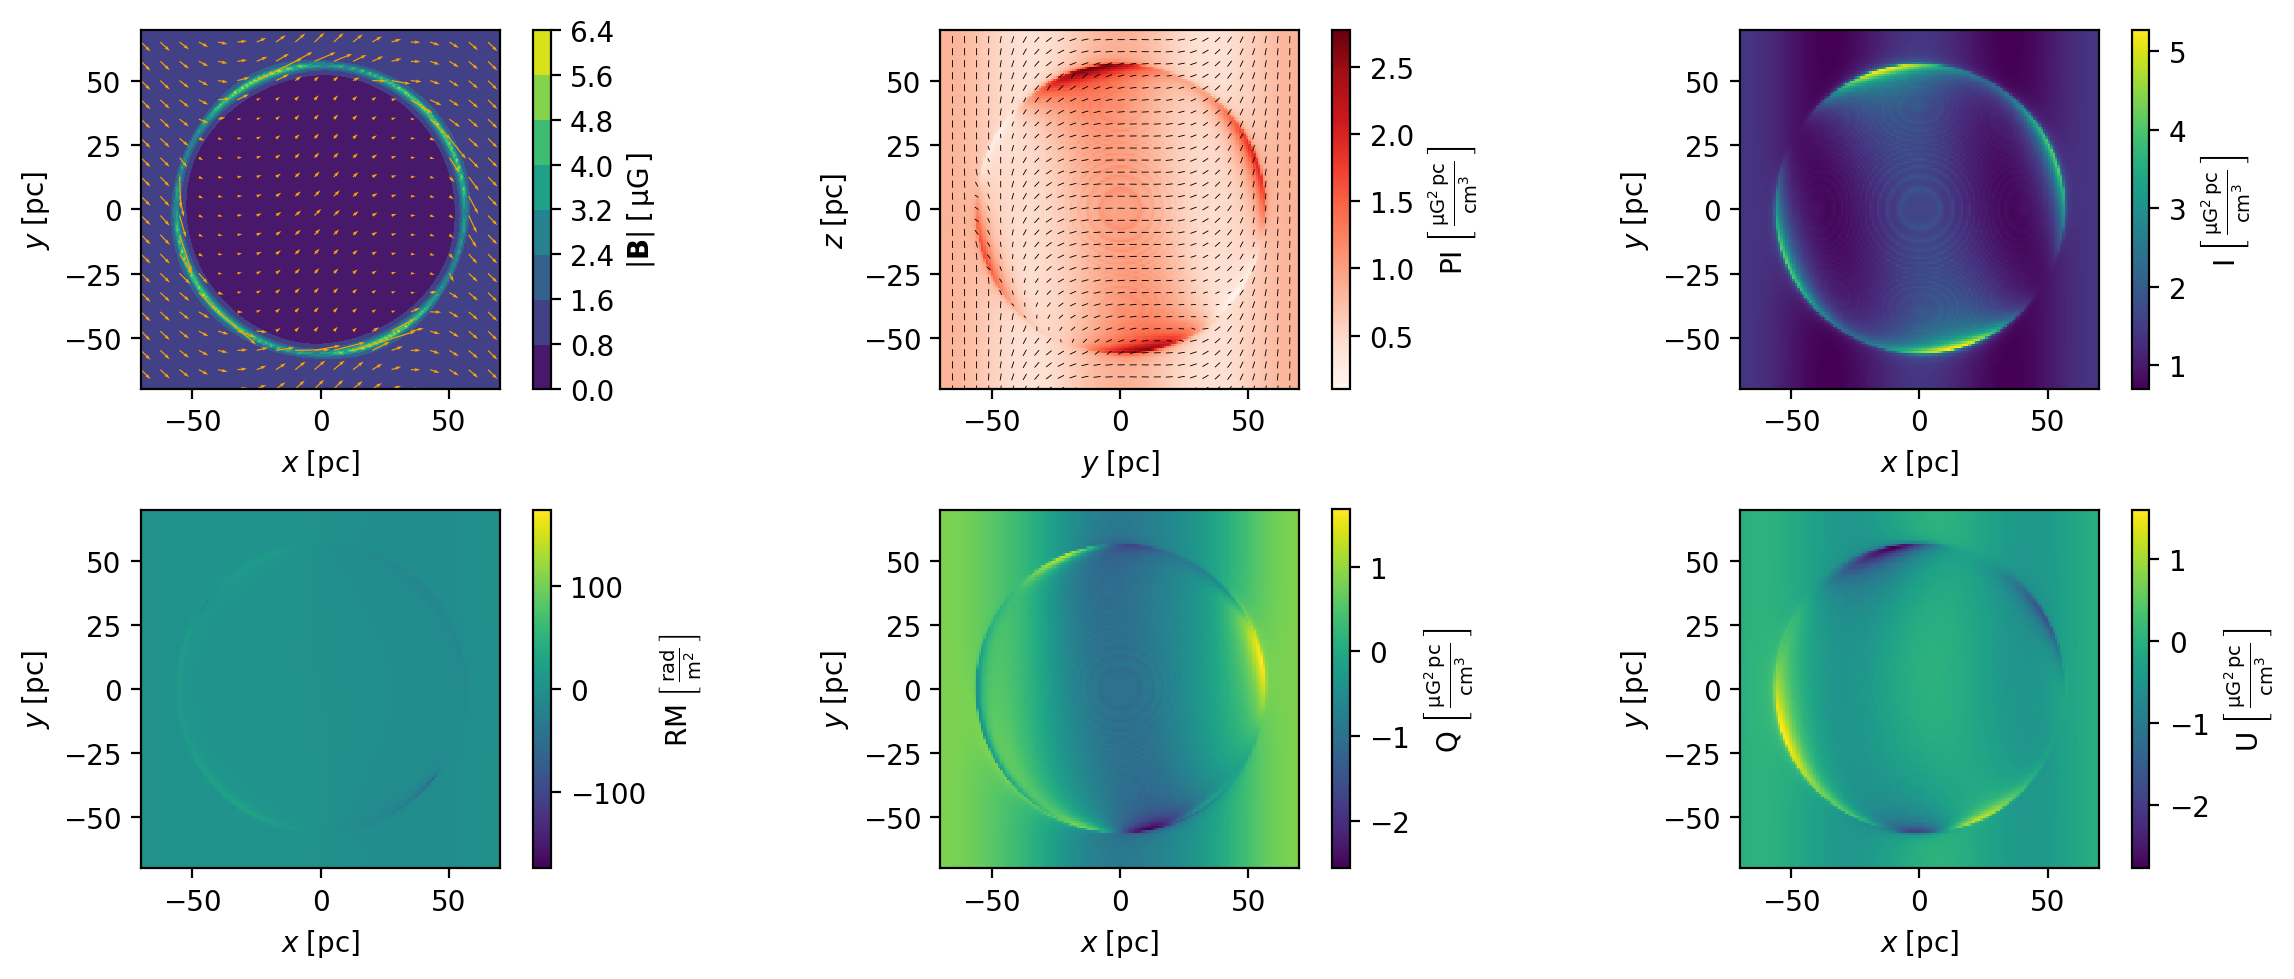

Model 8
  ncr_ne  ->  0.1
  ne      ->  0.1 1 / cm3
  freqs   ->  [1.4   1.401] GHz
  cr_type ->  uniform
  B       ->  [1. 0. 0.] uG
  Brnd_B  ->  0
  shell_a ->  1.3
  shell_b ->  15
  B_type  ->  helical
  period  ->  35.0 pc


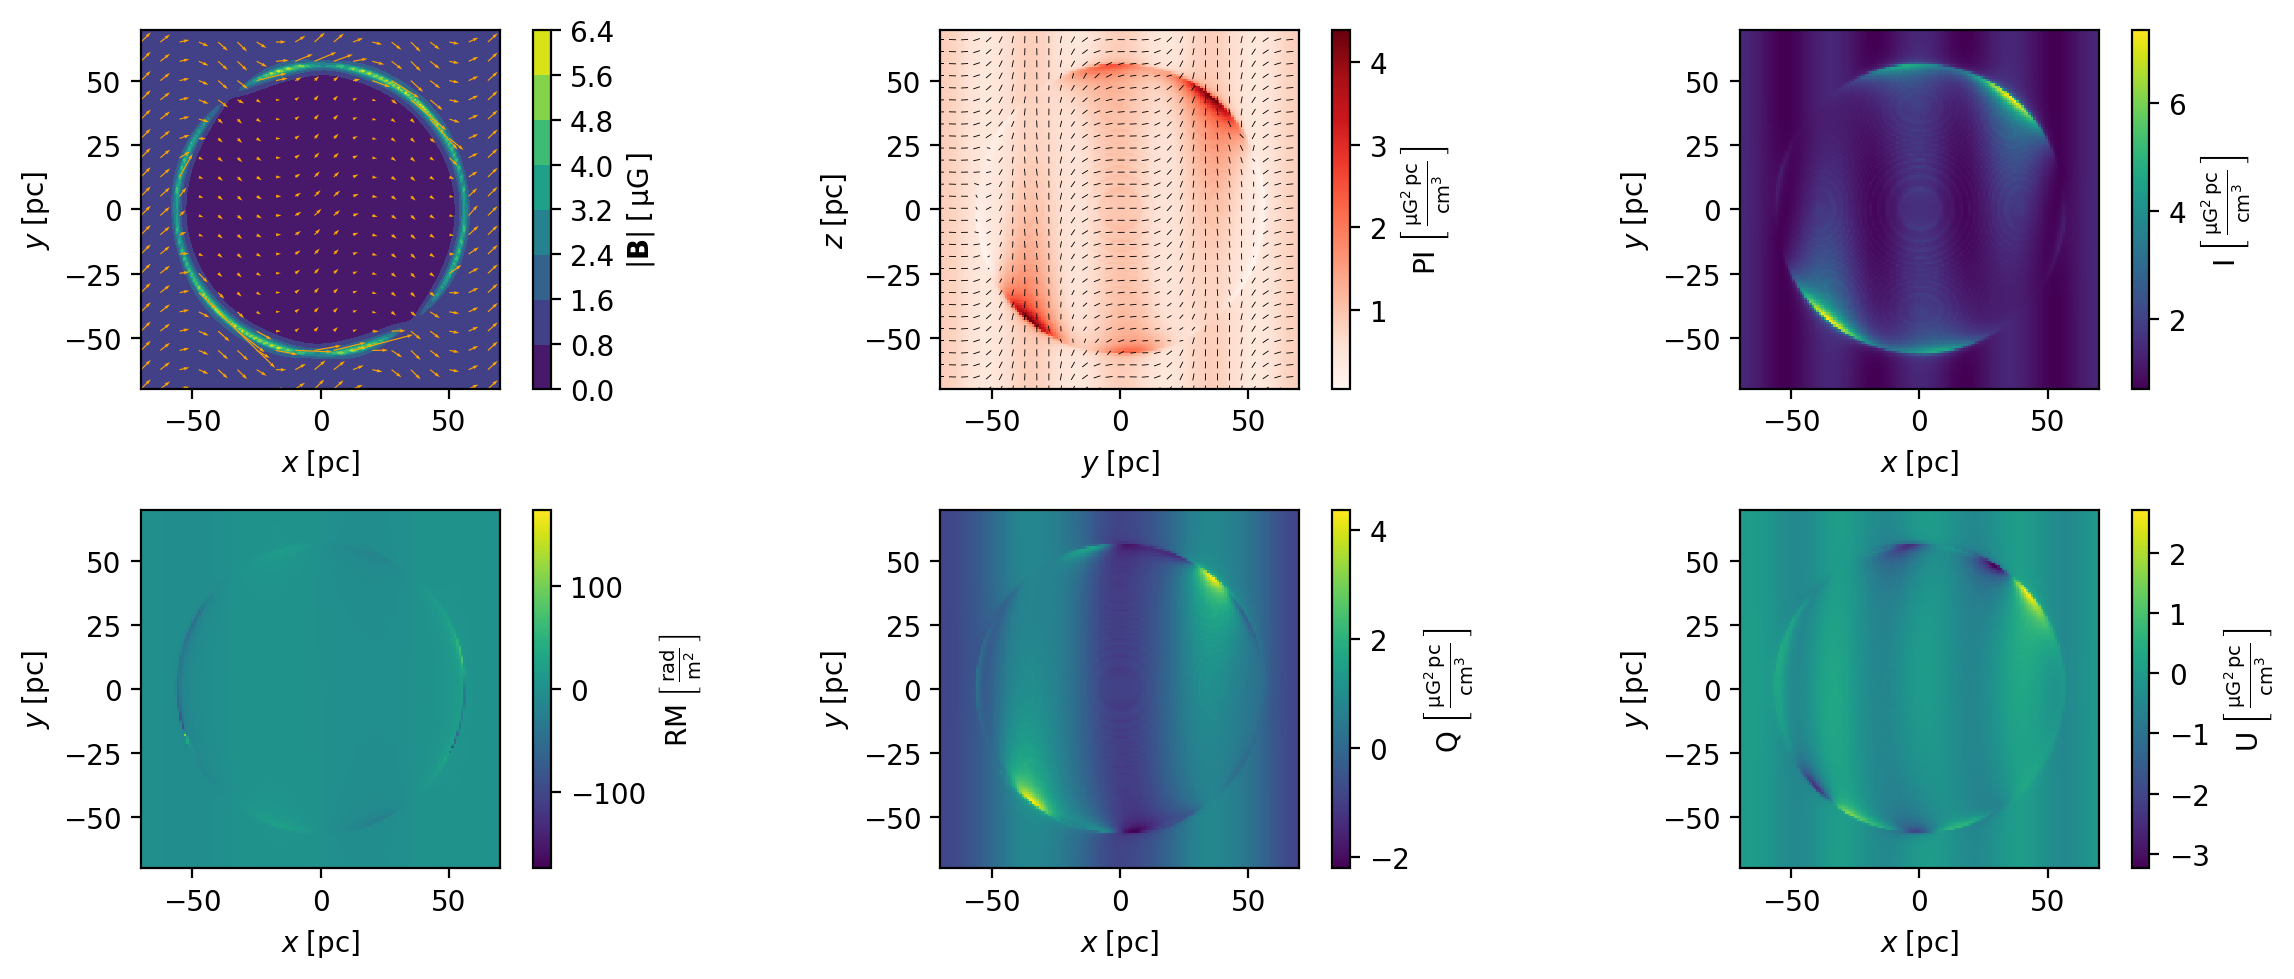

Model 9
  ncr_ne  ->  0.1
  ne      ->  0.1 1 / cm3
  freqs   ->  [1.4   1.401] GHz
  cr_type ->  uniform
  B       ->  [1. 0. 0.] uG
  Brnd_B  ->  0
  shell_a ->  1.3
  shell_b ->  15
  B_type  ->  helical
  period  ->  140.0 pc


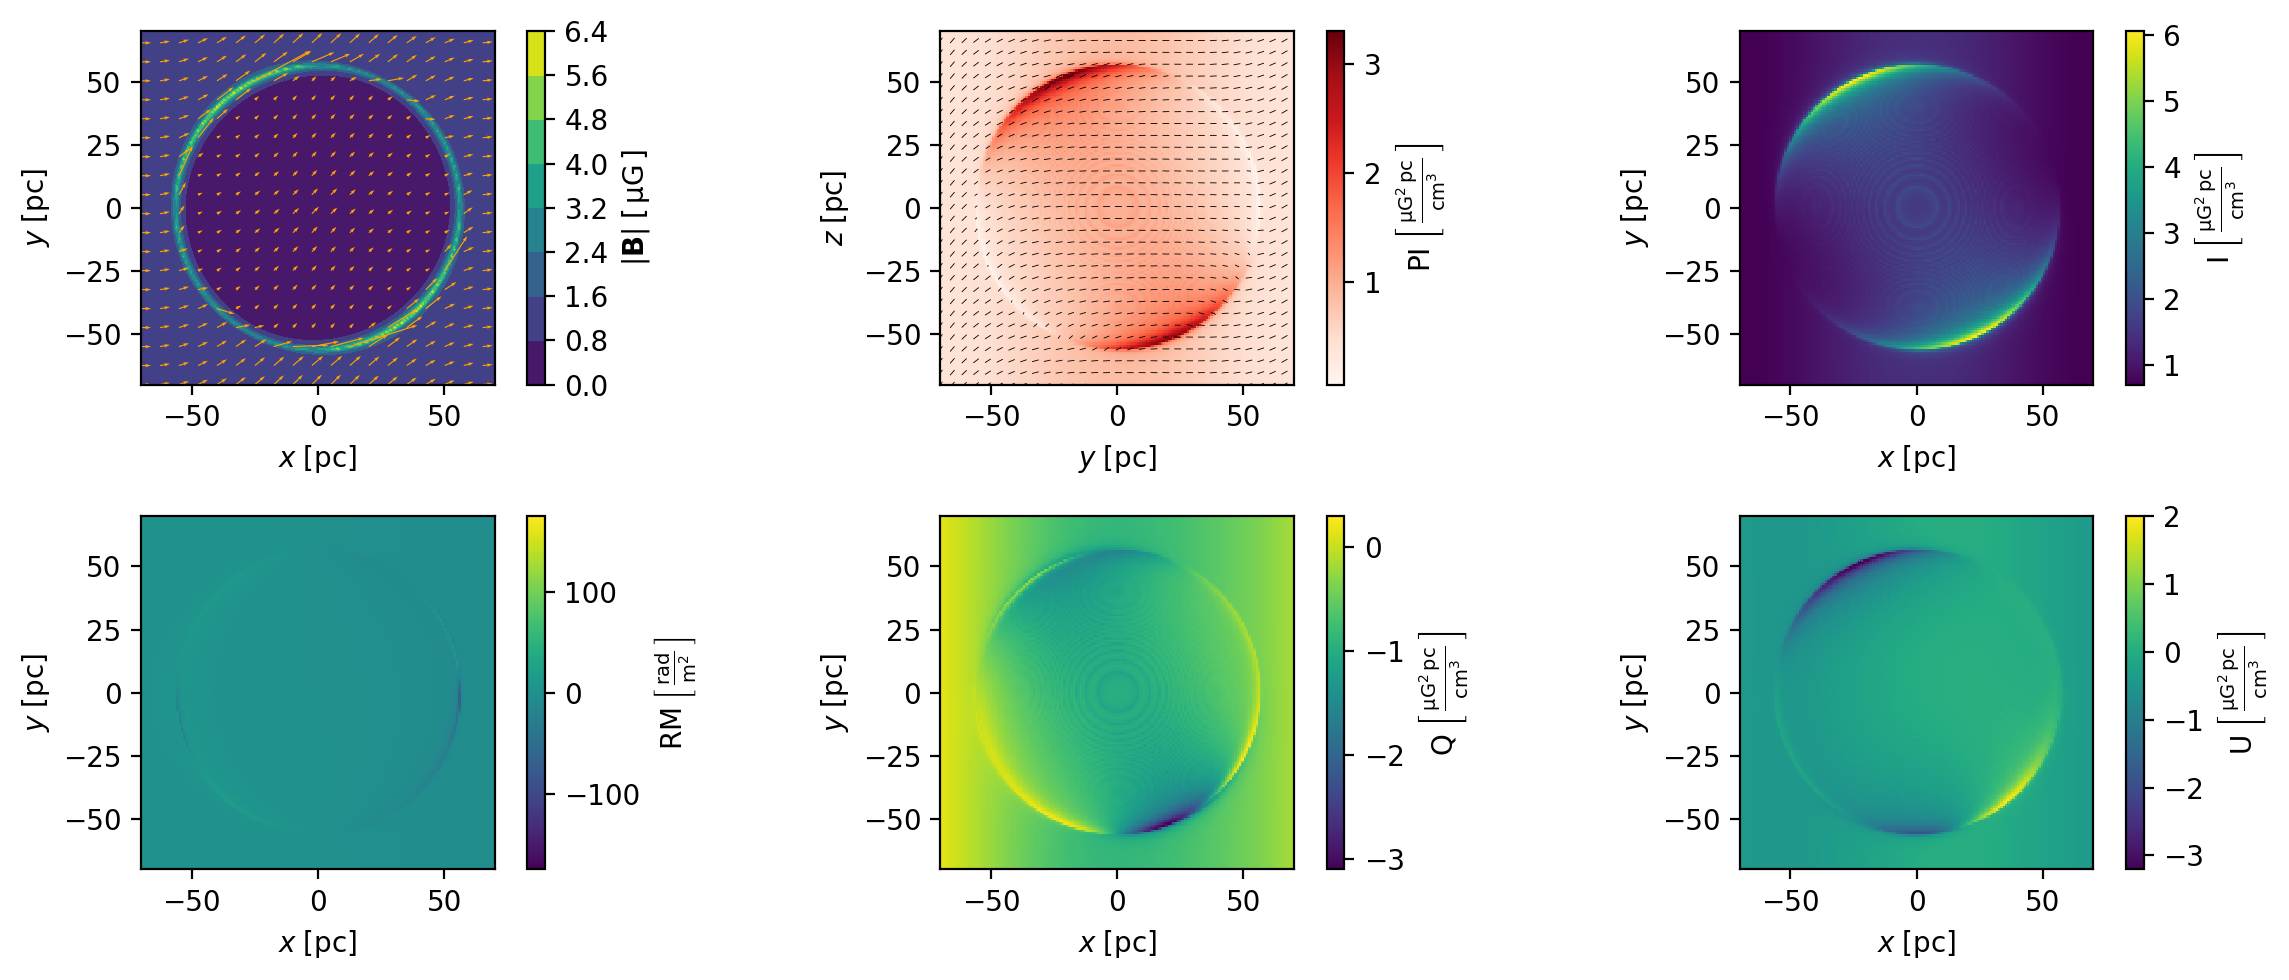

Model 10
  ncr_ne  ->  0.1
  ne      ->  0.1 1 / cm3
  freqs   ->  [1.4   1.401] GHz
  cr_type ->  uniform
  B       ->  [1. 0. 0.] uG
  Brnd_B  ->  0
  shell_a ->  0.7
  shell_b ->  10
  B_type  ->  helical
  period  ->  70.0 pc


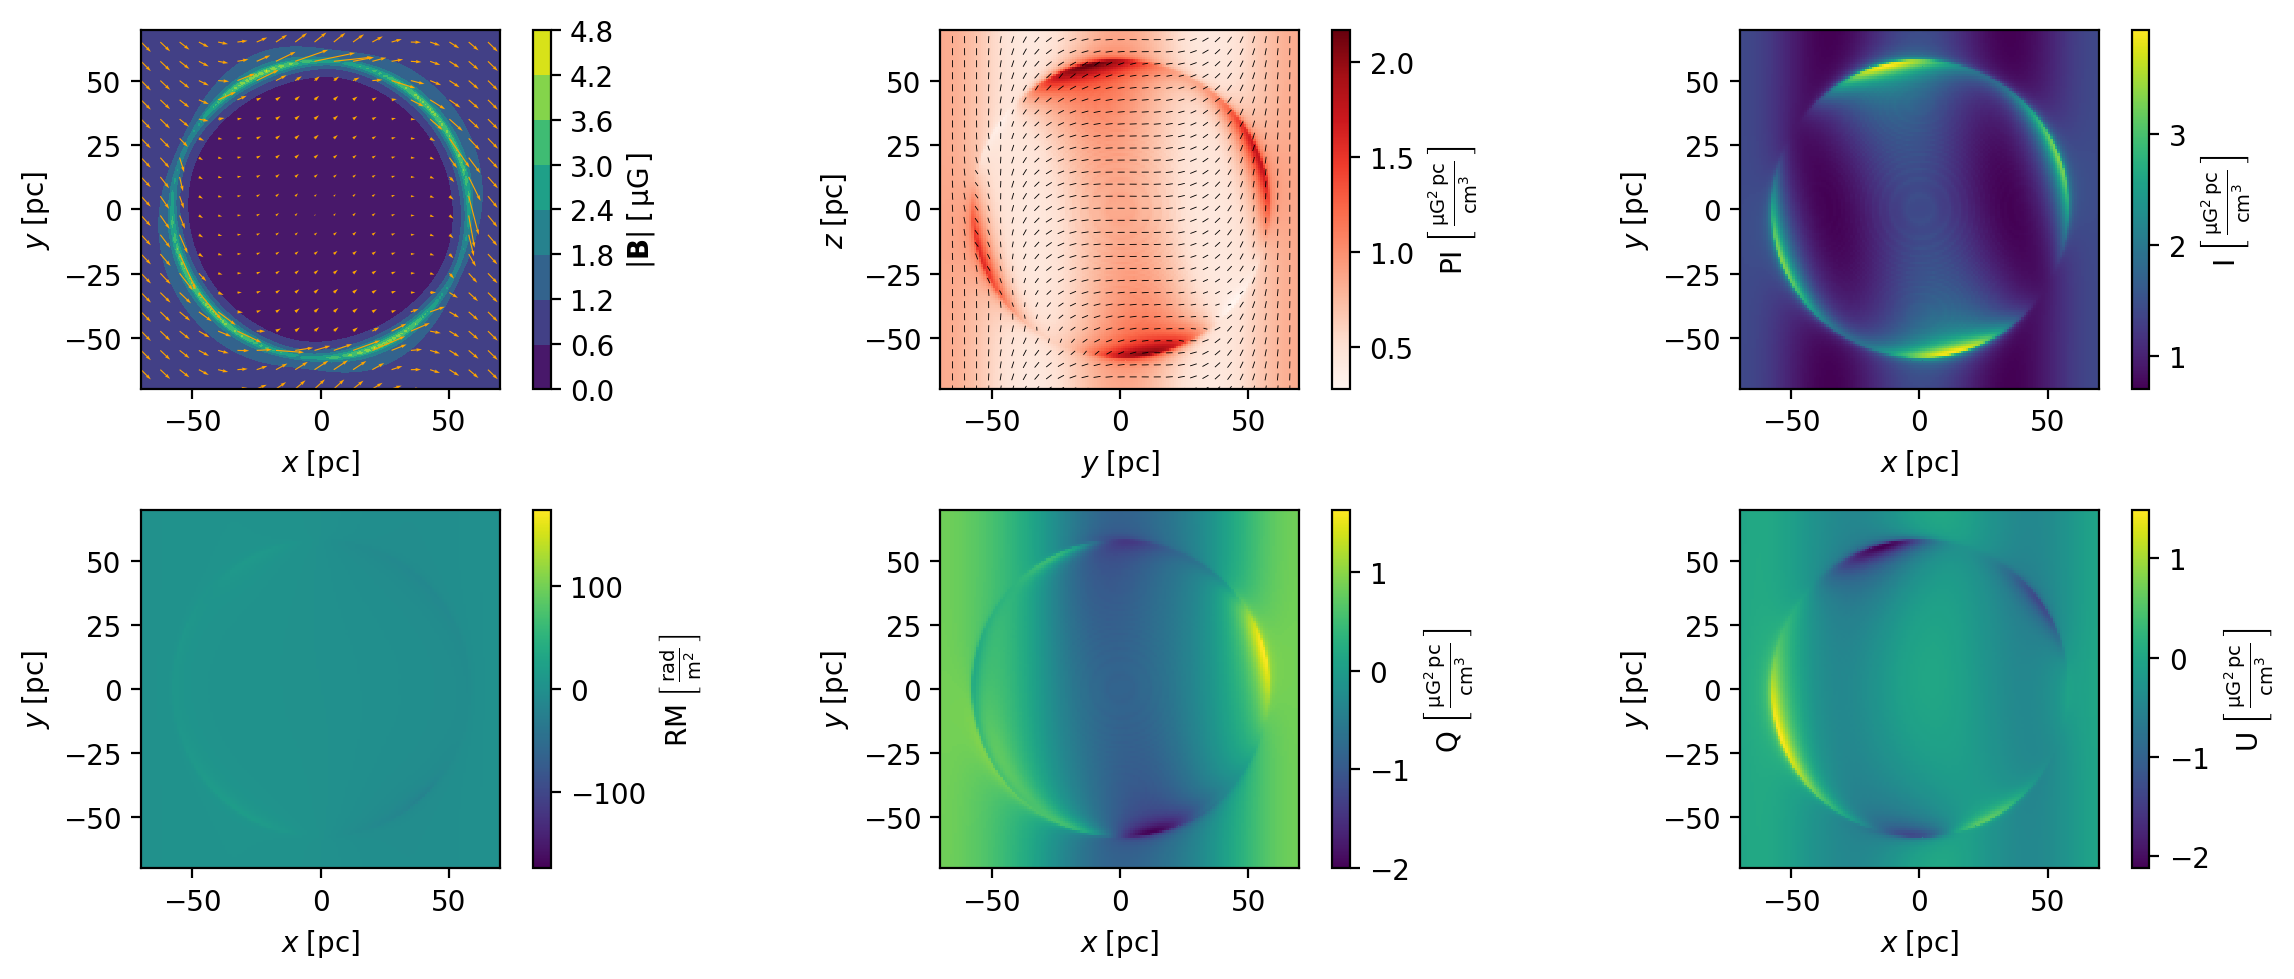

Model 11
  ncr_ne  ->  0.1
  ne      ->  0.1 1 / cm3
  freqs   ->  [1.4   1.401] GHz
  cr_type ->  uniform
  B       ->  [1. 0. 0.] uG
  Brnd_B  ->  0
  shell_a ->  0.7
  shell_b ->  10
  B_type  ->  helical
  period  ->  35.0 pc


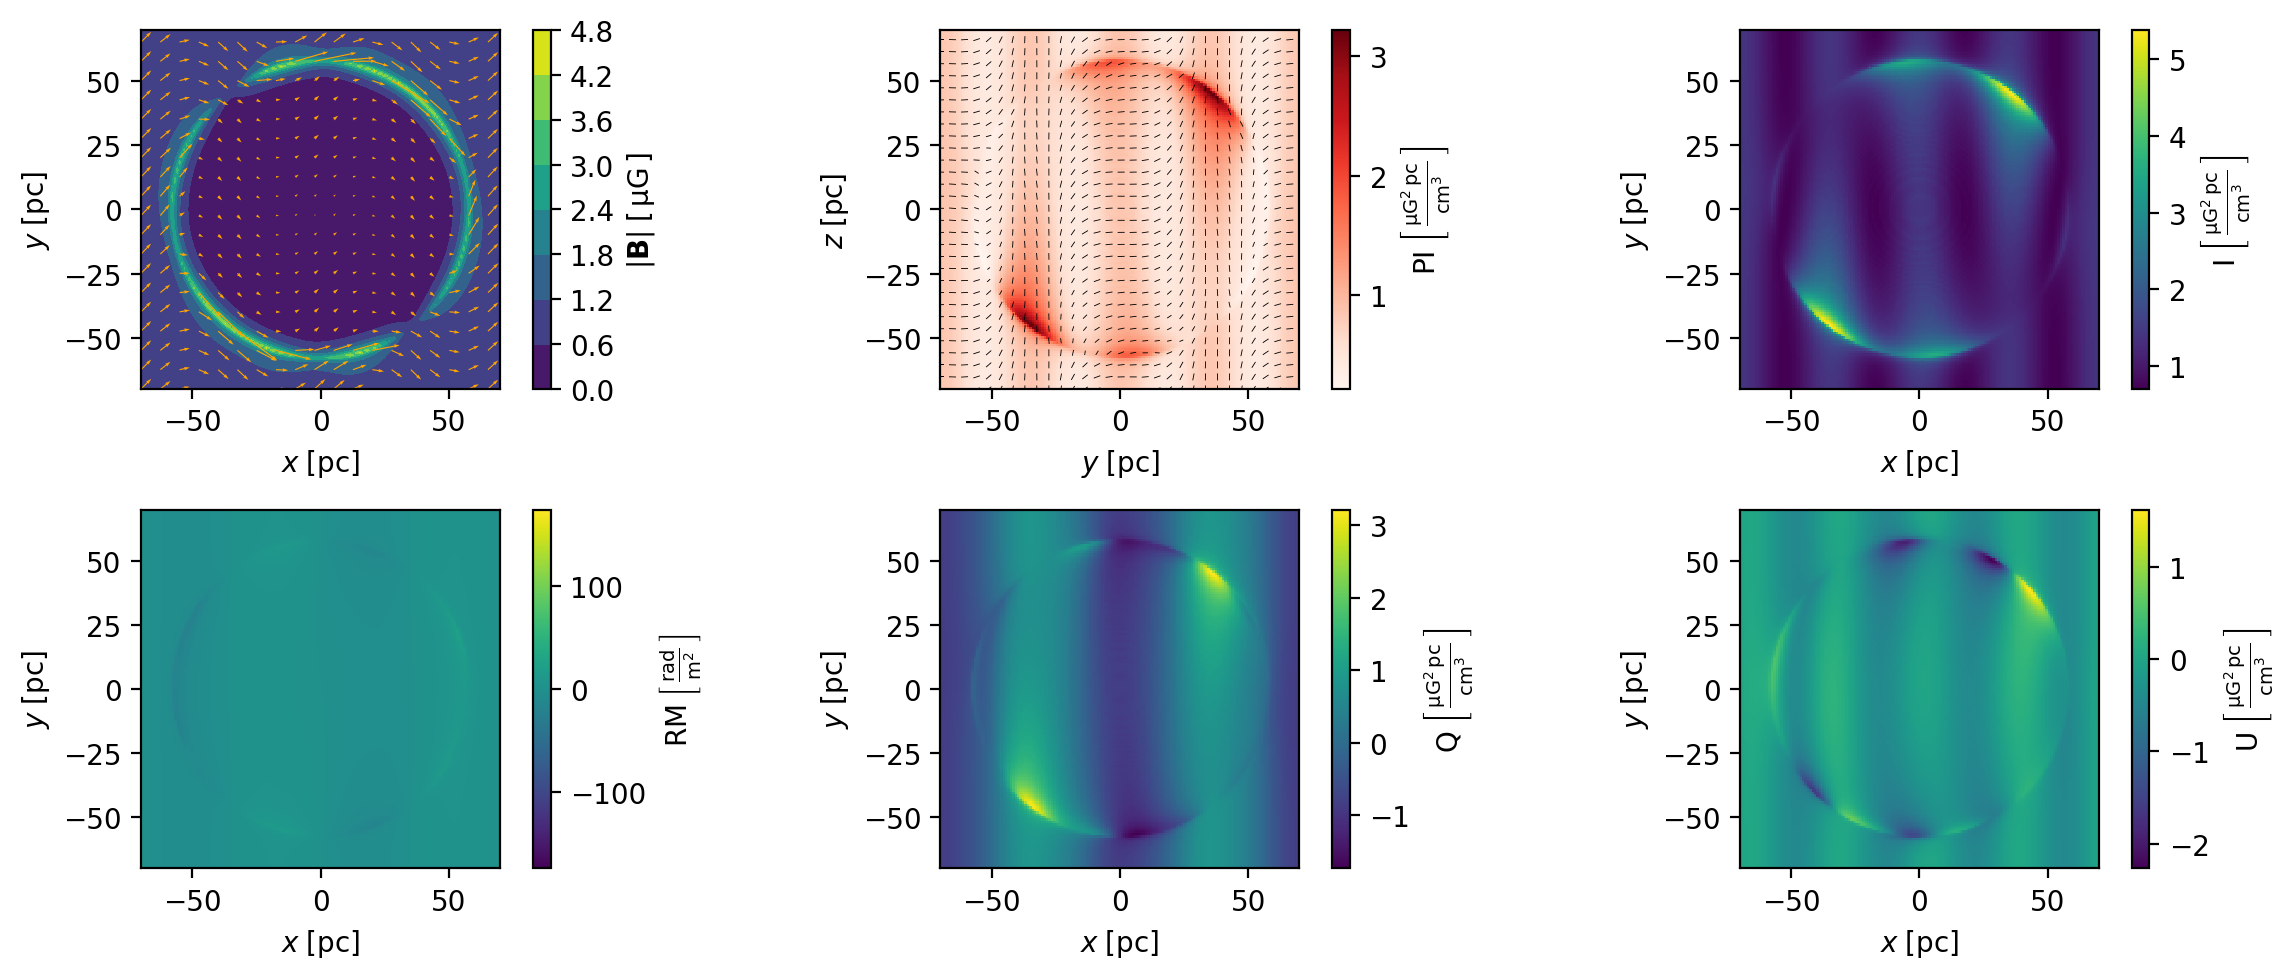

Model 12
  ncr_ne  ->  0.1
  ne      ->  0.1 1 / cm3
  freqs   ->  [1.4   1.401] GHz
  cr_type ->  uniform
  B       ->  [1. 0. 0.] uG
  Brnd_B  ->  0
  shell_a ->  0.7
  shell_b ->  10
  B_type  ->  helical
  period  ->  140.0 pc


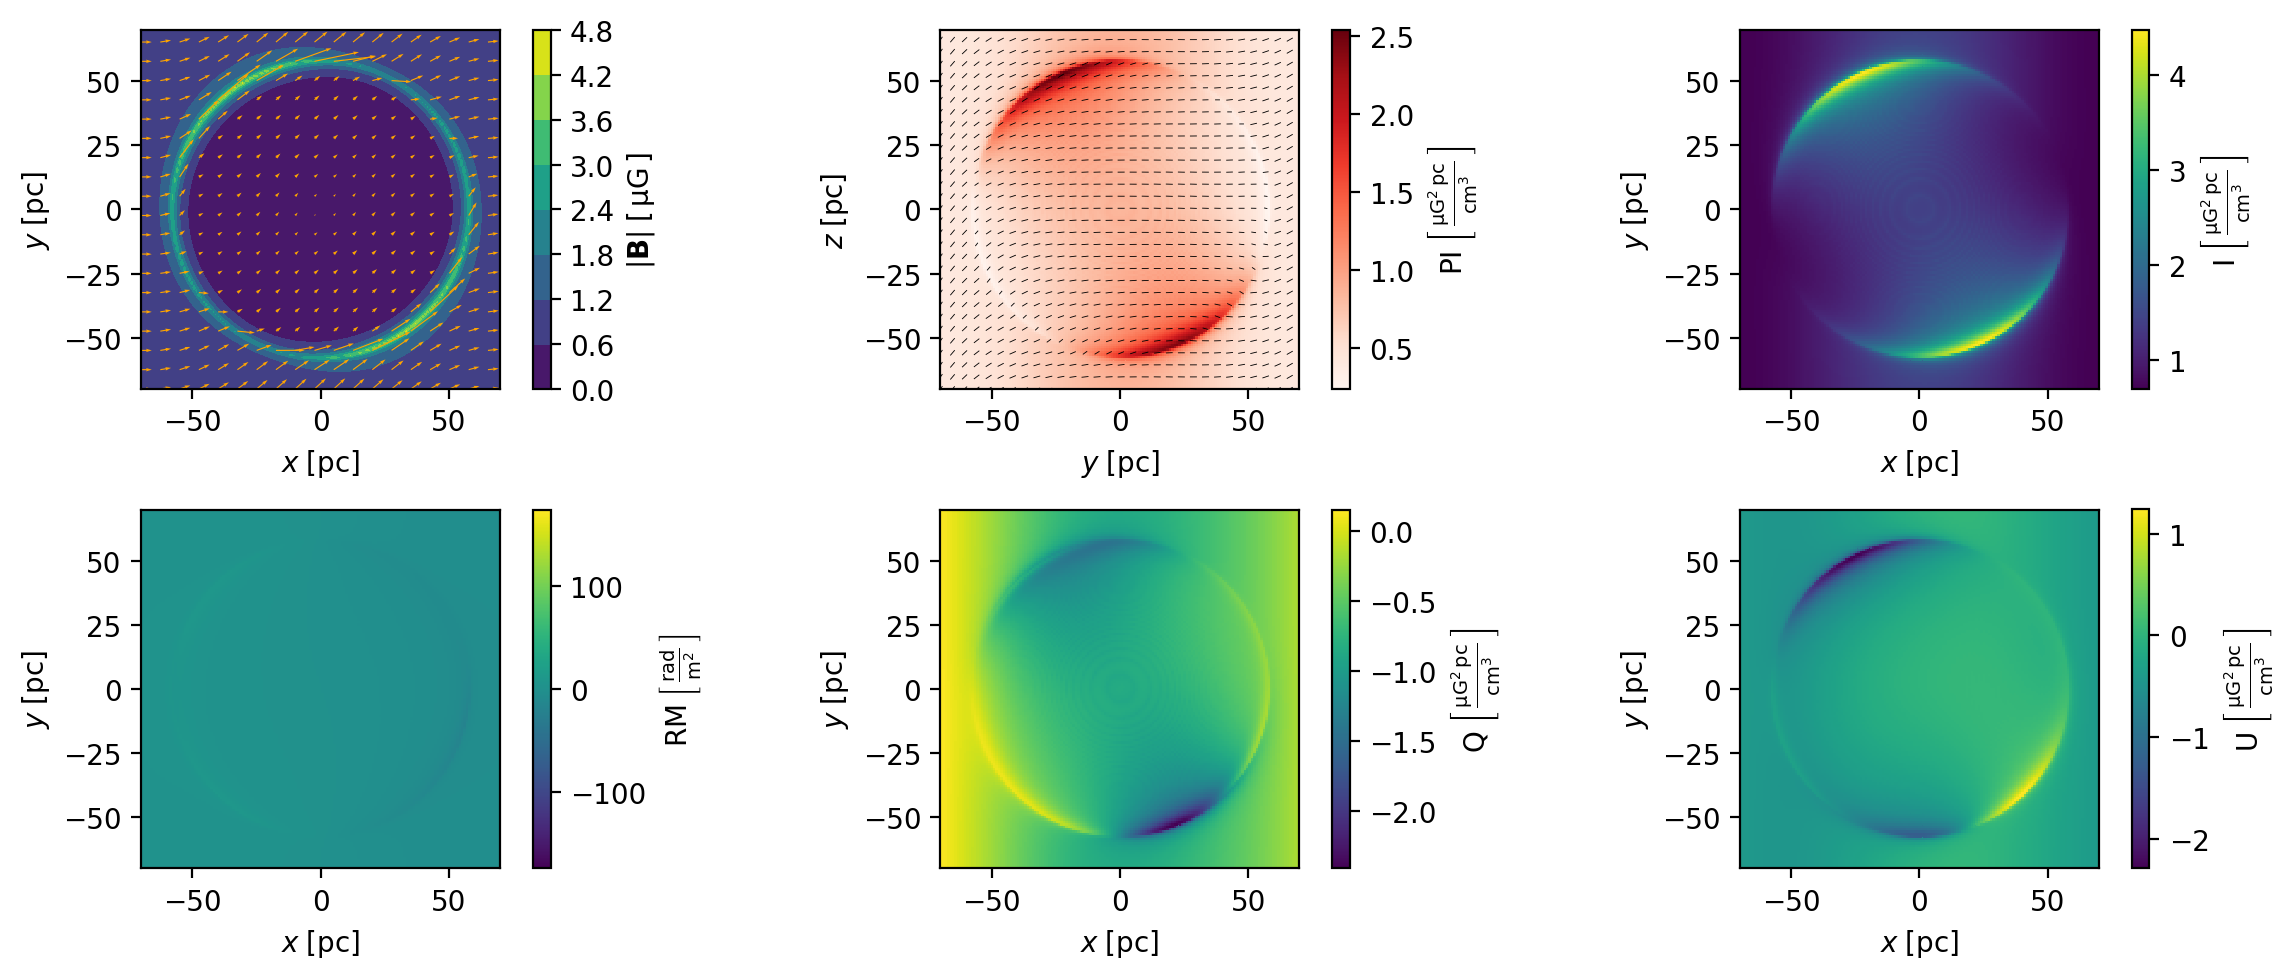

In [15]:
for i, params in enumerate(permutations_dicts):
    # Prints the parameters used
    print_param_dict(i, params)
    # Evaluates the model
    test_model = helper.Model(grid, **params)
    # Plots the panels
    show_model(grid, test_model)
    plt.show()
    if i > 10:
        break